In [113]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from tqdm import tqdm
%matplotlib inline

dataset_path = './data/images'
json_path = './data/datasetXGN/annotations/'
txt_path = './data/datasetXGN/yolo_annotations/'
eye_path = './data/eye_images'
eye_label_path = './datasets/siamese'


# EDA

In [114]:
relations = pd.read_csv("./data/datasetXGN/relations.csv", header=None)
relations.columns = ['category', 'number']
relations.head(10)

,category,number
0,B05-6045278,606803
1,B01-6455003,606803
2,B02-6113358,606803
3,B08-6372842,606803
4,B03-6192634,606803
5,B06-6148017,606803
6,D02098-08-2100,602828
7,D02098-95-12,602828
8,D02098-99-1000,602828
9,B10-6308948,602828


In [115]:
relations.shape
print(len(relations['category'].unique()))
print(len(relations['number'].unique()))


81751
46788


In [116]:
relations.drop_duplicates(
    subset=['category', 'number'], keep='first', inplace=True)
relations.shape


(227087, 2)

In [117]:
drop_indices = []
for idx, num in relations['number'].items():
    if not os.path.exists(os.path.join(dataset_path, str(num)+'.jpg')):
        drop_indices.append(idx)
relations.drop(drop_indices, inplace=True)
relations.shape


(203264, 2)

In [118]:
relations['number'].value_counts()[:1000]

182252    329
222808    315
36931     172
36577     158
563128    150
         ... 
370001     23
469047     23
629560     23
592537     23
629452     23
Name: number, Length: 1000, dtype: int64

(1006, 4018, 3)


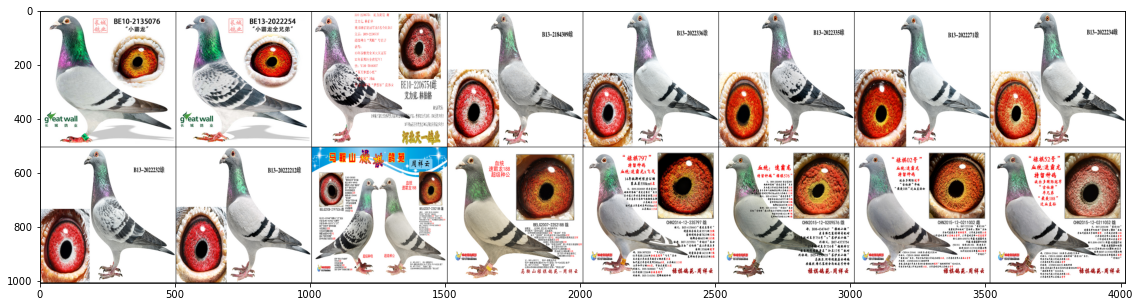

In [119]:
class ImageDataset(Dataset):
    def __init__(self, dir, images):
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Resize((500, 500))])
        self.images = images
        self.dir = dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        name = str(self.images[index])+'.jpg'
        img = Image.open(os.path.join(self.dir, name))
        img = self.transform(img)
        return img


def show_category(*cat):
    for i in cat:
        select_images = relations[relations['category']
                                  == i]['number'].values.tolist()
        dataset = ImageDataset(dataset_path, select_images)
        dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
        images = next(iter(dataloader))
        images = make_grid(images)
        images = images.numpy()
        images = images.transpose((1, 2, 0))
        print(images.shape)
        plt.figure(figsize=(20, 5))
        plt.imshow(images)
        plt.show()


show_category("B07-2135301")


# Convert

In [22]:
import os
import json
import shutil

def convert(width, height, box):

    x = (box[0] + box[2]) / 2.0 / width
    y = (box[1] + box[3]) / 2.0 / height
    w = (box[2] - box[0]) / width
    h = (box[3] - box[1]) / height

    return (x, y, w, h)


def is_legal(width, height, box):
    return (box[0] < box[2] <= width) and (box[1] < box[3] <= height)


In [24]:
if os.path.exists(txt_path):
    shutil.rmtree(txt_path)
os.makedirs(txt_path)
for json_file in os.listdir(json_path):
    data = json.load(open(os.path.join(json_path, json_file), 'r'))
    if data['bbs']:
        box = data['bbs'][0]['bbx']
        if is_legal(data['weidth'], data['height'], box):
            with open(os.path.join(txt_path, '%s.txt' % data["img"].split('.')[0]), 'w') as f:
                new_box = convert(data['weidth'], data['height'], box)
                f.write("%s %s %s %s %s\n" %
                        ('0', new_box[0], new_box[1], new_box[2], new_box[3]))
print(len(os.listdir(json_path)), " -> ", len(os.listdir(txt_path)))


9975  ->  9793


In [25]:
if os.path.exists(eye_path):
    shutil.rmtree(eye_path)
os.makedirs(eye_path)
for json_file in os.listdir(json_path):
    data = json.load(open(os.path.join(json_path, json_file), 'r'))
    if data['bbs']:
        box = data['bbs'][0]['bbx']
        img = os.path.join(dataset_path, data['img'])
        if os.path.exists(img) and is_legal(data['weidth'], data['height'], box):
            img = Image.open(img)
            region = img.crop(box).convert('RGB')
            region.save(os.path.join(eye_path,data["img"].split('.')[0]+'.jpg'))


D:\Anaconda\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41988
  "Possibly corrupt EXIF data.  "
D:\Anaconda\lib\site-packages\PIL\TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 42240
  "Possibly corrupt EXIF data.  "


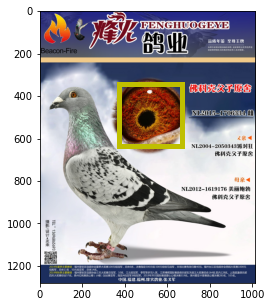

In [124]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import random

txt = random.choice(os.listdir(txt_path))
img_path = os.path.join(dataset_path, txt.split('.')[0]+'.jpg')
if os.path.exists(img_path):
    with open(os.path.join(txt_path, txt), 'r') as f:
        category, x, y, w, h = f.readline().split()
        img = Image.open(img_path)
        w = float(w) * img.size[0]
        h = float(h) * img.size[1]
        x = img.size[0] * float(x) - 0.5 * w
        y = img.size[1] * float(y) - 0.5 * h
        plt.figure(figsize=(10, 5))
        plt.imshow(img)
        current_axis = plt.gca()
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=5, edgecolor='y', facecolor='none')
        current_axis.add_patch(rect)


# YOLO

In [ ]:
import os
import shutil
import random
random.seed(17)

k = 2000
train = 0.8
txt_list = random.sample(os.listdir(txt_path), k)

yolo_path = {'train_image': './datasets/eyes/images/train', 'val_image': './datasets/eyes/images/val',
                'train_label': './datasets/eyes/labels/train', 'val_label': './datasets/eyes/labels/val'}
for path in yolo_path.values():
    if os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path)

for txt in txt_list[:int(k * train)]:
    img = os.path.join(dataset_path, txt.split('.')[0]+'.jpg')
    txt = os.path.join(txt_path, txt)
    if os.path.exists(img):
        shutil.copy(img, yolo_path['train_image'])
        shutil.copy(txt, yolo_path['train_label'])
for txt in txt_list[int(k * train):]:
    img = os.path.join(dataset_path, txt.split('.')[0]+'.jpg')
    txt = os.path.join(txt_path, txt)
    if os.path.exists(img):
        shutil.copy(img, yolo_path['val_image'])
        shutil.copy(txt, yolo_path['val_label'])

In [ ]:
!python train.py --img 640 --batch 4 --epochs 3 --data eyes.yaml --weights yolov5s.pt

In [ ]:
!python export.py --weights ./runs/train/exp6/weights/best.pt --img 640 --batch 1

# Dataset

In [125]:
import random
from itertools import combinations, product
from tqdm import tqdm
num_cat = 80
img_numbers = [int(i.split(".")[0]) for i in os.listdir(eye_path)]
img_relations = relations[relations['number'].isin(img_numbers)]

select_cat = img_relations['category'].value_counts().index[:num_cat]
img_relations = img_relations[img_relations['category'].isin(select_cat)].reset_index(drop=True)
print(img_relations.shape)
img_relations['category'].value_counts()

(3345, 2)


B98-3158062    169
B06-3008003    120
B01-6455003     93
B98-6335690     82
N94-1651476     81
              ... 
B93-6228515     28
B10-2045207     28
B96-6286060     28
B99-6143733     28
B02-6091493     28
Name: category, Length: 80, dtype: int64

In [53]:
imgs_num = 6000
positive_num = 0.6 * imgs_num
negative_num = imgs_num - positive_num

positive_pairs = []
negative_pairs = []

positive_sample_num = img_relations['category'].value_counts().apply(
    lambda x: int(x/len(img_relations)*positive_num))

for cat, num in positive_sample_num.iteritems():
    imgs = img_relations[img_relations['category'] == cat]['number'].tolist()
    for _ in range(num):
        positive_pairs.append(random.sample(imgs, 2))


In [41]:
cat_num = img_relations['category'].value_counts()
cat_num = [(cat, num) for cat, num in cat_num.items()]
cat_combine = list(combinations(cat_num, 2))
cat_combine = [((c1[0], c2[0]), c1[1]*c2[1]) for (c1, c2) in cat_combine]
sum = 0
for i in cat_combine:
    sum += i[1]
cat_combine = [(c[0], int(c[1]/sum*negative_num) if int(c[1] /
                                                        sum*negative_num) > 0 else 1) for c in cat_combine]

for (cats, num) in tqdm(cat_combine):
    imgs_0 = img_relations[img_relations['category']
                           == cats[0]]['number'].tolist()
    imgs_1 = img_relations[img_relations['category']
                           == cats[1]]['number'].tolist()
    negative_pairs.extend(random.sample(list(product(imgs_0, imgs_1)), num))


100%|██████████| 3160/3160 [00:04<00:00, 637.37it/s]


In [42]:
train_size = 0.8
positive_size = int(train_size*len(positive_pairs))
negative_size = int(train_size*len(negative_pairs))
with open(os.path.join(eye_label_path, 'train_labels.txt'), 'w') as f:
    for i1, i2 in positive_pairs[:positive_size]:
        f.write('%s %s 1\n' % (i1, i2))
    for i1, i2 in negative_pairs[:negative_size]:
        f.write('%s %s 0\n' % (i1, i2))
with open(os.path.join(eye_label_path, 'test_labels.txt'), 'w') as f:
    for i1, i2 in positive_pairs[positive_size:]:
        f.write('%s %s 1\n' % (i1, i2))
    for i1, i2 in negative_pairs[negative_size:]:
        f.write('%s %s 0\n' % (i1, i2))


# Siamese

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms, models
from torch.optim import lr_scheduler
import torch.optim as optim
import os
from tqdm import tqdm


class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.embedding_net = models.mobilenet_v3_small(num_classes=10)

    def train_model(self, x1, x2):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        return output1, output2

    def forward(self, x):
        return self.embedding_net(x)


class ContrastiveLoss(nn.Module):
    """
    Contrastive loss
    Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise
    """

    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-9

    def forward(self, output1, output2, target, size_average=True):
        distances = (output2 - output1).pow(2).sum(1)  # squared distances
        losses = 0.5 * (target.float() * distances +
                        (1 + -1 * target).float() * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
        return losses.mean() if size_average else losses.sum()


class SiameseDataset(Dataset):
    """
    Train: For each sample creates randomly a positive or a negative pair
    Test: Creates fixed pairs for testing
    """

    def __init__(self, path, file, transform):
        self.images = []
        self.path = path
        self.transform = transform
        with open(file, 'r') as f:
            for i in f.read().splitlines():
                item = i.split(' ')
                self.images.append(((item[0], item[1]), item[2]))

    def __getitem__(self, index):

        ((img1, img2), label) = self.images[index]
        img1 = Image.open(os.path.join(self.path, str(img1)+'.jpg'))
        img2 = Image.open(os.path.join(self.path, str(img2)+'.jpg'))
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return (img1, img2), int(label)

    def __len__(self):
        return len(self.images)


In [126]:
import numpy as np
import cv2
import random
import os

calc_list = os.listdir(eye_path)
calc_num = 1000
img_h, img_w = 100, 100
imgs = np.zeros([img_w, img_h, 3, 1])
means, stdevs = [], []

for i in range(calc_num):
    img_path = calc_list[i]

    img = cv2.imread(os.path.join(eye_path, img_path))
    img = cv2.resize(img, (img_h, img_w))

    img = img[:, :, :, np.newaxis]
    imgs = np.concatenate((imgs, img), axis=3)


imgs = imgs.astype(np.float32)/255.
for i in range(3):
    pixels = imgs[:, :, i, :].ravel()
    means.append(np.mean(pixels))
    stdevs.append(np.std(pixels))
means.reverse()
stdevs.reverse()

print("norm_mean = {}".format(means))
print("norm_std = {}".format(stdevs))
print('transforms.Normalize(mean = {}, std = {})'.format(means, stdevs))


norm_mean = [0.57382727, 0.36730826, 0.3031635]
norm_std = [0.28851405, 0.29145136, 0.29022723]
transforms.Normalize(mean = [0.57382727, 0.36730826, 0.3031635], std = [0.28851405, 0.29145136, 0.29022723])


In [ ]:
n_epochs = 35
batch_size = 64
margin = 1.
lr = 1e-3
cuda = True
eye_path = './data/eye_images'
eye_label_path = './datasets/siamese'

transform = transforms.Compose(
    [transforms.Resize((100, 100)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.574, 0.367, 0.303], std=[0.289, 0.291, 0.290])])
siamese_train_dataset = SiameseDataset(eye_path, os.path.join(
    eye_label_path, 'train_labels.txt'), transform)
siamese_test_dataset = SiameseDataset(eye_path, os.path.join(
    eye_label_path, 'test_labels.txt'), transform)


siamese_train_loader = torch.utils.data.DataLoader(
    siamese_train_dataset, batch_size=batch_size, shuffle=True)
siamese_test_loader = torch.utils.data.DataLoader(
    siamese_test_dataset, batch_size=batch_size, shuffle=False)


model = SiameseNet()
if cuda:
    model.cuda()

loss_fn = ContrastiveLoss(margin)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)


for ep in range(n_epochs):
    total_loss = 0
    for batch_idx, (data, target) in tqdm(enumerate(siamese_train_loader)):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()

        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (
            tuple, list) else loss_outputs
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(ep+1, ' ', total_loss)


In [ ]:
with torch.no_grad():
    model.eval()
    val_loss = 0
    for batch_idx, (data, target) in enumerate(siamese_test_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()

        outputs = model.train_model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)
        assert batch_idx == 1
        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        val_loss += loss.item()
    print(val_loss)

In [ ]:
import numpy as np

def cos_sim(vector_a, vector_b):
    """
    计算两个向量之间的余弦相似度
    :param vector_a: 向量 a 
    :param vector_b: 向量 b
    :return: sim
    """
    vector_a = np.mat(vector_a)
    vector_b = np.mat(vector_b)
    num = float(vector_a * vector_b.T)
    denom = np.linalg.norm(vector_a) * np.linalg.norm(vector_b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim

print(target)
if cuda:
    for i in range(8):
        a = outputs[0][i].cpu().detach().numpy()
        b = outputs[1][i].cpu().detach().numpy()
        print(i, cos_sim(a,b))
else:
    for i in range(8):
        a = outputs[0][i].numpy()
        b = outputs[1][i].numpy()
        print(i, cos_sim(a,b))

In [ ]:
import json
import shutil
sample_path = "./datasets/samples"
model = torch.load("./models/model_80_6000_feat10_mobile.ptl")
transform = transforms.Compose(
    [transforms.Resize((100, 100)), transforms.ToTensor(), transforms.Normalize(mean=[0.574, 0.367, 0.303], std=[0.289, 0.291, 0.290])])

select_sample_cat = img_relations['category'].value_counts().index[:10]
print(select_sample_cat)
sample_relations = img_relations[img_relations['category'].isin(
    select_sample_cat)].reset_index(drop=True)
sample_num = sample_relations['category'].value_counts().apply(
    lambda x: int(x/len(sample_relations)*100))
print(sample_num)

sample_images = {}
img_list = []
for cat, num in sample_num.iteritems():
    imgs = sample_relations[sample_relations['category'] == cat]['number'].tolist()[
        :num]
    for i in imgs:
        shutil.copy(os.path.join(eye_path,str(i)+'.jpg'),os.path.join(sample_path,str(i)+'.jpg'))
        img = Image.open(os.path.join(eye_path, str(i)+'.jpg'))
        img = transform(img).unsqueeze(0)  # .cuda()
        feature = model(img).numpy().tolist()[0]
        img_dict = {"id": str(i)+'.jpg', "category": cat, "feature": feature}
        img_list.append(img_dict)

sample_images['images'] = img_list

with open('images_gpu.json', 'w') as f:
    json.dump(sample_images, f)


In [103]:
sample_relations

,category,number
0,B98-3158062,603415
1,B01-6455003,602913
2,B01-6455003,385895
3,B06-3008003,682469
4,B98-3158062,683624
...,...,...
860,B98-3158062,284886
861,B01-6455003,334949
862,B01-6455003,334951
863,B01-6455003,396804
